In [1]:
import os
import shutil
import time
import json

In [2]:
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, Sequential, Input
from keras.src.applications.convnext import ConvNeXtXLarge
from keras.src.applications.efficientnet_v2 import EfficientNetV2L
from keras.src.applications.inception_resnet_v2 import InceptionResNetV2
from keras.src.applications.resnet_v2 import ResNet50V2
from keras.src.applications.vgg16 import VGG16
from keras.src.applications.xception import Xception
from keras.src.callbacks import ModelCheckpoint, EarlyStopping
from keras.src.utils import image_dataset_from_directory
from pandas import DataFrame
from plot_keras_history import show_history

2024-09-28 10:16:38.087949: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-28 10:16:38.782693: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
CROPPED_IMAGES_PATH = "resources/Cropped_Images"
MODELS_PATH = "models/transfer_learning"

In [4]:
def remove_last_generated_models():
    shutil.rmtree(MODELS_PATH, ignore_errors=True)
    os.makedirs(MODELS_PATH)

In [5]:
def get_dataset(path, batch_size, image_size, validation_split=0.0, data_type=None):
    return image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        class_names=None,
        batch_size=batch_size,
        image_size=image_size,
        seed=42,
        validation_split=validation_split,
        subset=data_type
    )

In [6]:
def create_model(image_size, base_model):
    input_shape = image_size + (3,)
    
    for layer in base_model.layers:
        layer.trainable = False
        
    data_augmentation_layers = Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1)
    ])
    
    model = Sequential([
        Input(shape=input_shape),
        
        # Data augmentation
        data_augmentation_layers,

        # Pre-trained model without the top
        base_model,

        # Convert the feature map from the encoder part of the model (without the top) to a vector
        layers.GlobalAveragePooling2D(),

        # Fully connected layers (all neurons are linked to the others).
        layers.Dense(256, activation='relu'),

        # Dropout layer to prevent overfitting. Randomly stops some neurons for each image so that the other neurons have to adapt to that, to reduce overfitting.
        layers.Dropout(0.2),

        # Output layer with the same layer as your labels. Softmax to allow the model to predict the probability of each class.
        layers.Dense(120, activation='softmax')
    ])

    # Crossentropy as we're getting closer to a correct prediction of the labels.
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    # print(model.summary())
    return model

In [7]:
def get_base_model(base_model, image_size):
    input_shape = image_size + (3,)
    preprocessing_input = Input(shape=input_shape)
    
    match base_model:
        case "VGG16":
            return (VGG16(include_top=False, weights="imagenet", input_tensor=keras.applications.vgg16.preprocess_input(preprocessing_input)))
        case "Xception":
            return (Xception(include_top=False, weights="imagenet", input_tensor=keras.applications.xception.preprocess_input(preprocessing_input)))
        case "ResNet50V2":
            return (ResNet50V2(include_top=False, weights="imagenet", input_tensor=keras.applications.resnet_v2.preprocess_input(preprocessing_input)))
        case "InceptionResNetV2":
            return (InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=keras.applications.inception_resnet_v2.preprocess_input(preprocessing_input)))
            
        case "EfficientNetV2L":
            # The preprocessing logic has been included in the EfficientNetV2 model implementation.
            return EfficientNetV2L(include_top=False, weights="imagenet")
        case "ConvNeXtXLarge":
            # The preprocessing logic has been included in the convnext model implementation.
            return ConvNeXtXLarge(include_top=False, weights="imagenet")
            
        case _:
            return None

In [8]:
def display_results_plots(results):
    display_results_plot(results, ["fitting_time"], "fitting_time")
    display_results_plot(results, ["test_accuracy", "val_accuracy"], "accuracies", ascending=False)
    display_results_plot(results, ["test_loss", "val_loss"], "losses")

In [9]:
def display_results_plot(results, metrics, metrics_name, ascending=True):
    results.sort_values(metrics[0], ascending=ascending, inplace=True)

    performance_plot = (results[metrics + ["model_name"]]
                        .plot(kind="line", x="model_name", figsize=(15, 8), rot=0,
                              title=f"Models Sorted by {metrics_name}"))
    performance_plot.title.set_size(20)
    performance_plot.set_xticks(range(0, len(results)))
    performance_plot.set(xlabel=None)

    plt.show()
    plt.close()

Starting transfer learning script.

Found 20580 files belonging to 120 classes.
Using 15435 files for training.


2024-09-28 10:16:40.820044: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-28 10:16:40.864942: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-28 10:16:40.867818: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 20580 files belonging to 120 classes.
Using 5145 files for validation.
Found 20580 files belonging to 120 classes.
Training model VGG16.

Epoch 1/100


2024-09-28 10:16:45.191625: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1930/1930 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2383 - loss: 3.9789
Epoch 1: val_loss improved from inf to 1.25783, saving model to models/transfer_learning/VGG16_best_weights.keras
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 73s 36ms/step - accuracy: 0.2384 - loss: 3.9782 - val_accuracy: 0.6138 - val_loss: 1.2578
Epoch 2/100
1929/1930 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5368 - loss: 1.6256
Epoch 2: val_loss improved from 1.25783 to 1.22194, saving model to models/transfer_learning/VGG16_best_weights.keras
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 69s 36ms/step - accuracy: 0.5368 - loss: 1.6255 - val_accuracy: 0.6470 - val_loss: 1.2219
Epoch 3/100
1929/1930 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5799 - loss: 1.4382
Epoch 3: val_loss improved from 1.22194 to 1.12370, saving model to models/transfer_learning/VGG16_best_weights.keras
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 69s 36ms/step - accuracy: 0.5799 - loss: 1.4382 - val_accuracy: 0.6706 - val_loss: 1.1237
Epoch 4/100
1929/1930 ━━━━━━━

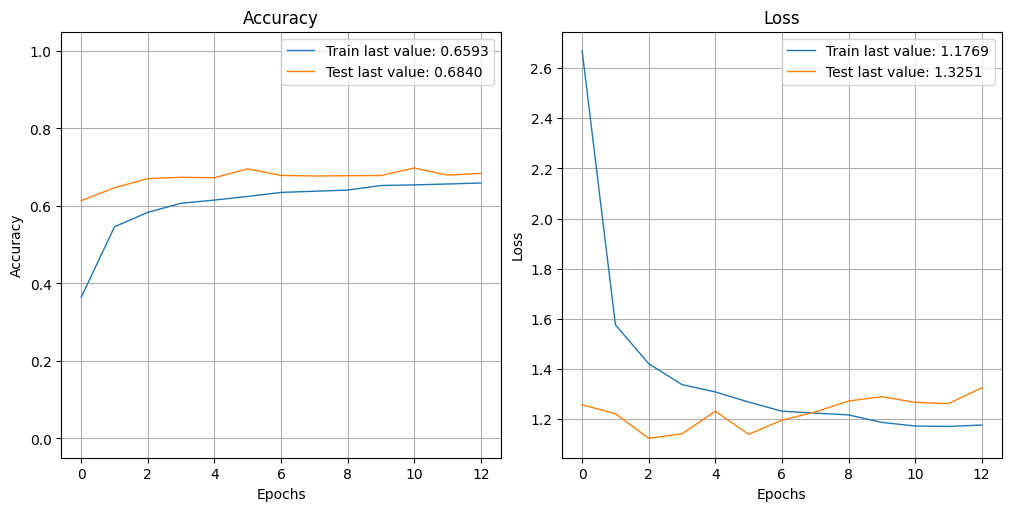

Training model Xception.

Epoch 1/100
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6247 - loss: 1.6055
Epoch 1: val_loss improved from inf to 0.50563, saving model to models/transfer_learning/Xception_best_weights.keras
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 56s 27ms/step - accuracy: 0.6248 - loss: 1.6052 - val_accuracy: 0.8354 - val_loss: 0.5056
Epoch 2/100
1927/1930 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7891 - loss: 0.7268
Epoch 2: val_loss improved from 0.50563 to 0.48853, saving model to models/transfer_learning/Xception_best_weights.keras
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 52s 27ms/step - accuracy: 0.7891 - loss: 0.7269 - val_accuracy: 0.8463 - val_loss: 0.4885
Epoch 3/100
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7922 - loss: 0.7044
Epoch 3: val_loss did not improve from 0.48853
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 51s 27ms/step - accuracy: 0.7922 - loss: 0.7044 - val_accuracy: 0.8430 - val_loss: 0.5127
Epoch 4/100
1927/1930 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 

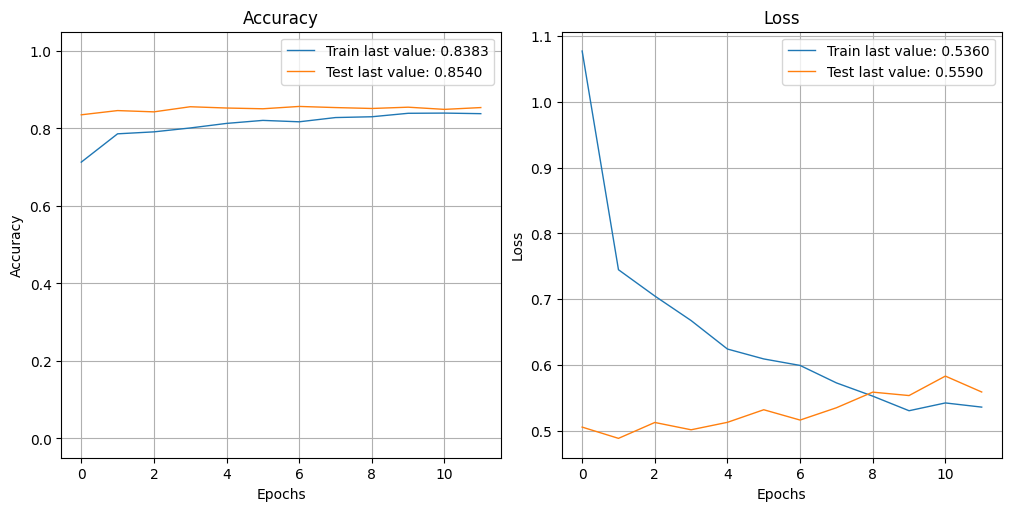

Training model ResNet50V2.

Epoch 1/100
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5031 - loss: 2.0706
Epoch 1: val_loss improved from inf to 0.74837, saving model to models/transfer_learning/ResNet50V2_best_weights.keras
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 52s 25ms/step - accuracy: 0.5031 - loss: 2.0702 - val_accuracy: 0.7679 - val_loss: 0.7484
Epoch 2/100
1927/1930 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7079 - loss: 0.9479
Epoch 2: val_loss did not improve from 0.74837
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 46s 24ms/step - accuracy: 0.7079 - loss: 0.9479 - val_accuracy: 0.7705 - val_loss: 0.7687
Epoch 3/100
1927/1930 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7387 - loss: 0.8746
Epoch 3: val_loss did not improve from 0.74837
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 46s 24ms/step - accuracy: 0.7387 - loss: 0.8746 - val_accuracy: 0.7695 - val_loss: 0.7680
Epoch 4/100
1927/1930 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7524 - loss: 0.8228
Epoch 4: val_loss improved from 0.74

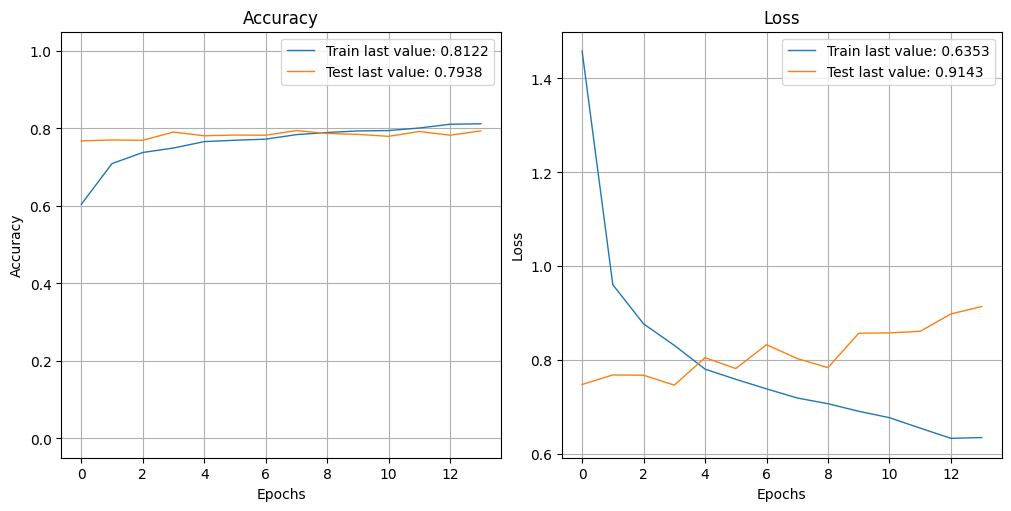

Training model InceptionResNetV2.

Epoch 1/100
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6853 - loss: 1.4310
Epoch 1: val_loss improved from inf to 0.44705, saving model to models/transfer_learning/InceptionResNetV2_best_weights.keras
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 102s 47ms/step - accuracy: 0.6854 - loss: 1.4308 - val_accuracy: 0.8651 - val_loss: 0.4471
Epoch 2/100
1929/1930 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8222 - loss: 0.6669
Epoch 2: val_loss improved from 0.44705 to 0.41688, saving model to models/transfer_learning/InceptionResNetV2_best_weights.keras
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 85s 44ms/step - accuracy: 0.8222 - loss: 0.6669 - val_accuracy: 0.8836 - val_loss: 0.4169
Epoch 3/100
1929/1930 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8244 - loss: 0.6486
Epoch 3: val_loss did not improve from 0.41688
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 84s 43ms/step - accuracy: 0.8244 - loss: 0.6486 - val_accuracy: 0.8840 - val_loss: 0.4414
Epoch 4/100
1929/1930 ━━━━━━

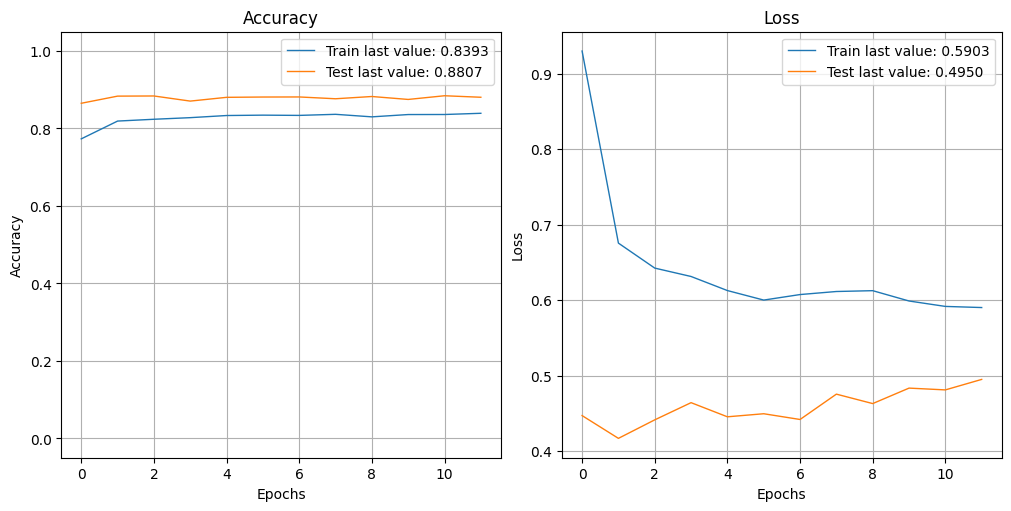

Training model EfficientNetV2L.

Epoch 1/100
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7945 - loss: 1.0697
Epoch 1: val_loss improved from inf to 0.31323, saving model to models/transfer_learning/EfficientNetV2L_best_weights.keras
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 216s 98ms/step - accuracy: 0.7946 - loss: 1.0694 - val_accuracy: 0.9102 - val_loss: 0.3132
Epoch 2/100
1929/1930 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8984 - loss: 0.3567
Epoch 2: val_loss did not improve from 0.31323
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 182s 94ms/step - accuracy: 0.8984 - loss: 0.3567 - val_accuracy: 0.9110 - val_loss: 0.3151
Epoch 3/100
1929/1930 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9035 - loss: 0.3235
Epoch 3: val_loss improved from 0.31323 to 0.31194, saving model to models/transfer_learning/EfficientNetV2L_best_weights.keras
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 185s 96ms/step - accuracy: 0.9035 - loss: 0.3235 - val_accuracy: 0.9118 - val_loss: 0.3119
Epoch 4/100
1929/1930 ━━━━━━━━━━

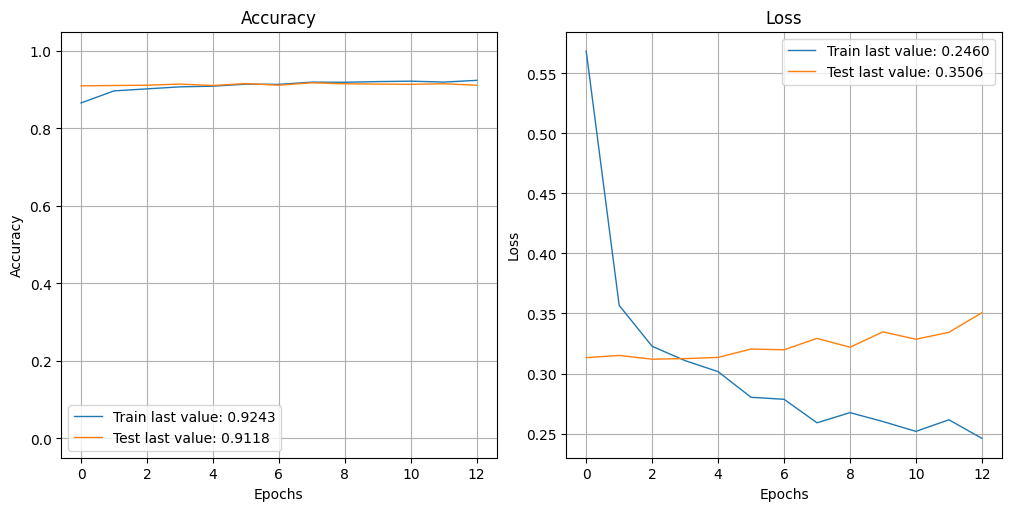

Training model ConvNeXtXLarge.

Epoch 1/100


I0000 00:00:1727499598.254805   10307 service.cc:145] XLA service 0x7cb600696220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727499598.254852   10307 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
I0000 00:00:1727499598.351354   10307 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1930/1930 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.7900 - loss: 0.9453
Epoch 1: val_loss improved from inf to 0.45929, saving model to models/transfer_learning/ConvNeXtXLarge_best_weights.keras
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 1255s 645ms/step - accuracy: 0.7901 - loss: 0.9451 - val_accuracy: 0.8756 - val_loss: 0.4593
Epoch 2/100
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.8928 - loss: 0.3762
Epoch 2: val_loss improved from 0.45929 to 0.42472, saving model to models/transfer_learning/ConvNeXtXLarge_best_weights.keras
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 1244s 645ms/step - accuracy: 0.8928 - loss: 0.3762 - val_accuracy: 0.8974 - val_loss: 0.4247
Epoch 3/100
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.9087 - loss: 0.3129
Epoch 3: val_loss did not improve from 0.42472
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 1240s 643ms/step - accuracy: 0.9087 - loss: 0.3129 - val_accuracy: 0.8976 - val_loss: 0.4424
Epoch 4/100
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0

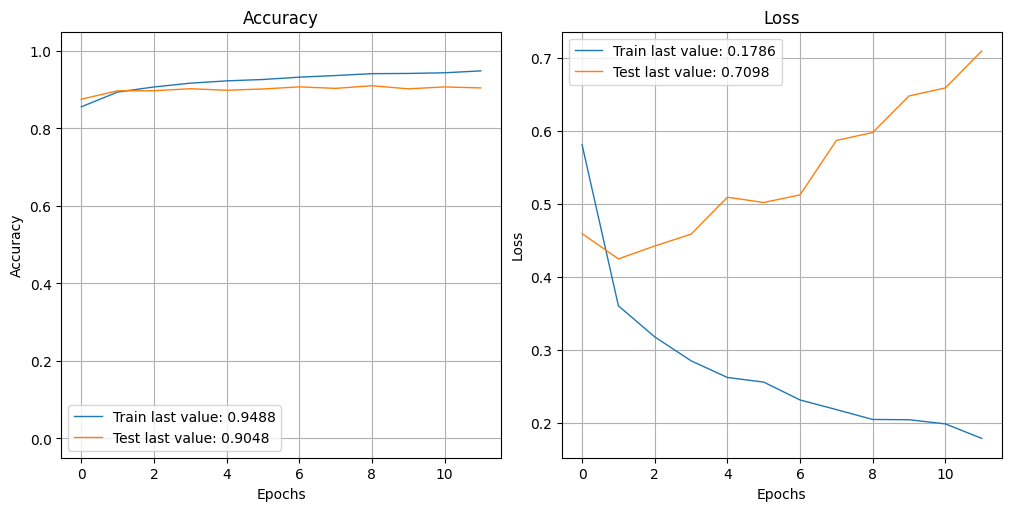

Displaying all results.



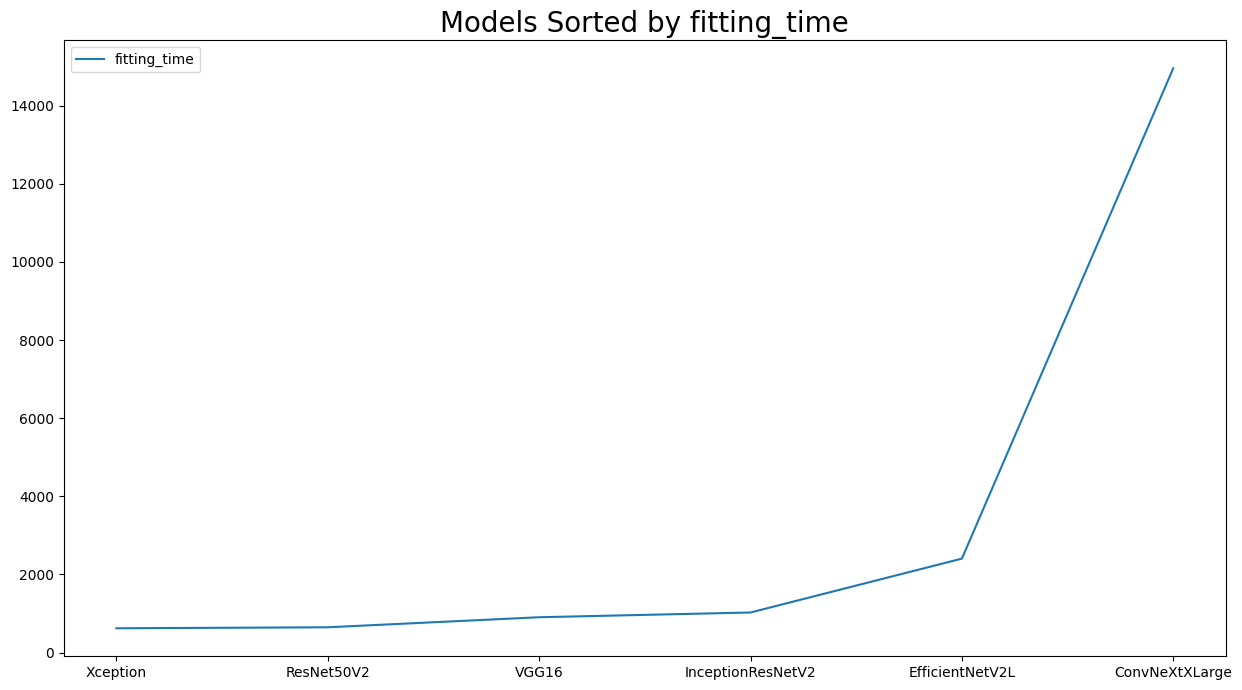

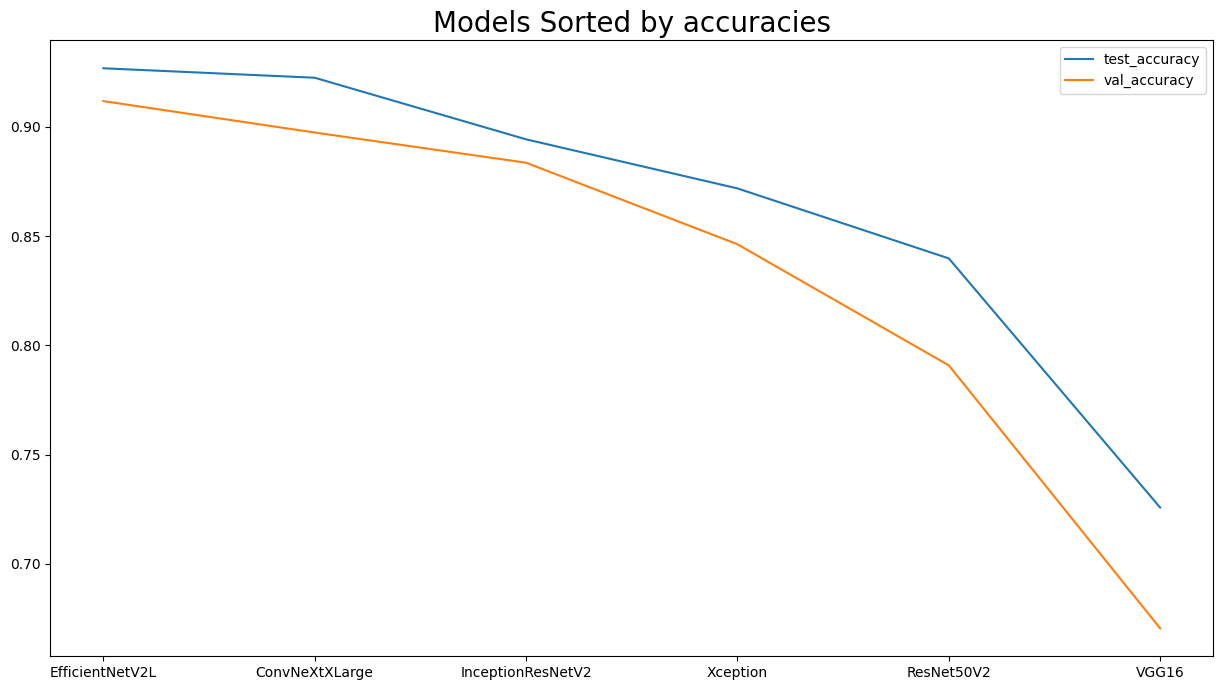

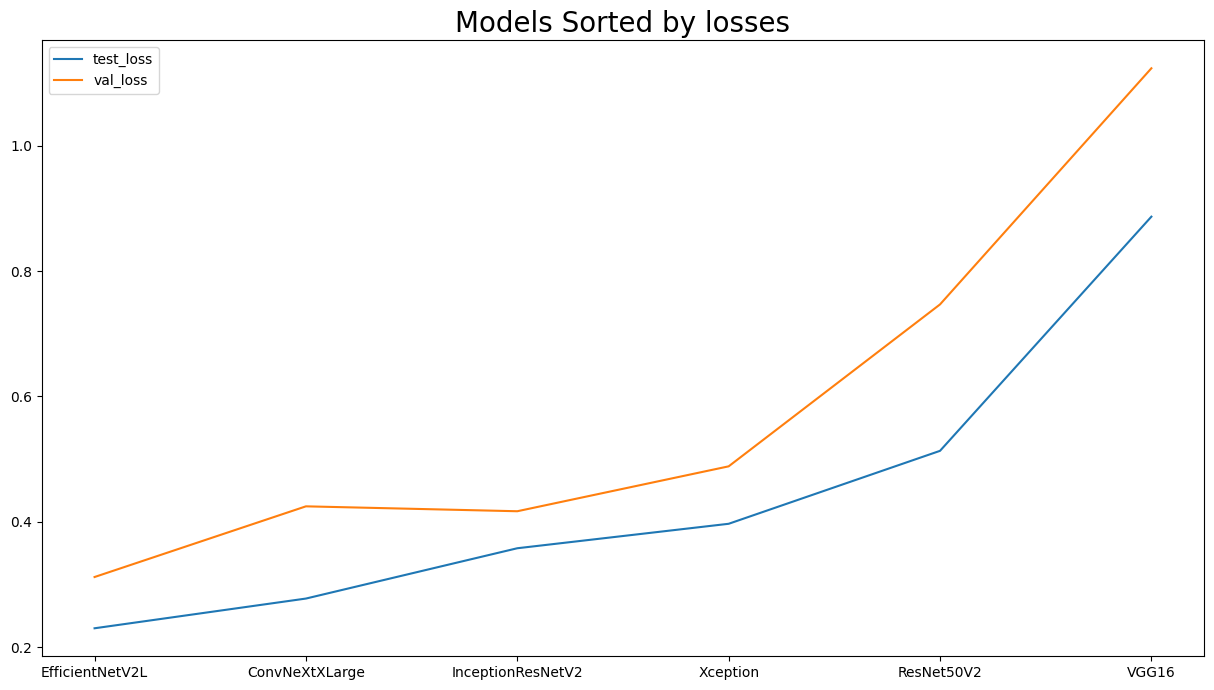

The transfer learning script is now finished.



In [10]:
print("Starting transfer learning script.\n")
remove_last_generated_models()

image_size = (224, 224)
batch_size = 8

dataset_train = get_dataset(CROPPED_IMAGES_PATH, batch_size, image_size, validation_split=0.25, data_type='training')
dataset_val = get_dataset(CROPPED_IMAGES_PATH, batch_size, image_size, validation_split=0.25, data_type='validation')
dataset_test = get_dataset(CROPPED_IMAGES_PATH, batch_size, image_size, data_type=None)

with tf.device('/gpu:0'):
    histories = []
    results = []
    
    for model_name in [
        "VGG16",
        "Xception",
        "ResNet50V2",
        "InceptionResNetV2",
        "EfficientNetV2L",
        "ConvNeXtXLarge"
    ]:
        print(f"Training model {model_name}.\n")

        base_model = get_base_model(model_name, image_size)

        model = create_model(image_size, base_model)
        model_save_path = f"{MODELS_PATH}/{model_name}_best_weights.keras"

        checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True,
                                     mode='min')
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        callbacks_list = [checkpoint, es]

        fitting_start_time = time.time()
        history = model.fit(dataset_train,
                            validation_data=dataset_val,
                            batch_size=batch_size,
                            epochs=100,  # We want early stopping to stop the training itself
                            callbacks=callbacks_list,
                            verbose=1)
        fitting_time = time.time() - fitting_start_time

        histories.append(history)
        print("The model has been fitted, checking their loss and accuracy.\n")

        # Getting optimal epoch weights
        model.load_weights(model_save_path)

        val_loss, val_accuracy = model.evaluate(dataset_val, verbose=False)
        print(f"\nValidation Accuracy:{val_accuracy}.\n")

        test_loss, test_accuracy = model.evaluate(dataset_test, verbose=False)
        print(f"\nTest Accuracy:{test_accuracy}.\n")

        # For future inference
        # model.export(f"{MODELS_PATH}/{model_name}_exported_model.keras")

        results.append({
            "model_name": model_name,
            "fitting_time": fitting_time,
            "test_accuracy": test_accuracy,
            "test_loss": test_loss,
            "val_accuracy": val_accuracy,
            "val_loss": val_loss
        })

        show_history(history)
        plt.close()
    
    print("Displaying all results.\n")
    display_results_plots(DataFrame(results))

print("The transfer learning script is now finished.\n")